In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from ridge import Ridge_
from sklearn.metrics import mean_absolute_error
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
predictor = 'Year'
target = 'Time'

In [3]:
df = pd.read_csv('olympics_100m.csv', sep=',')
X = df[predictor].values
y = df[target].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=True, random_state=42)

In [5]:
# Centering and normalizing the data so that the effect of the intercept
x_mean = X_train.mean()
x_std = X_train.std()

# scale the data
X_train = (X_train - x_mean) / x_std
X_train = X_train.reshape(len(X_train), 1)

In [6]:
X_test = (X_test - x_mean) / x_std
X_test = X_test.reshape(len(X_test), 1)

X_val = (X_val - x_mean) / x_std
X_val = X_val.reshape(len(X_val), 1)

In [7]:
poly = PolynomialFeatures(1)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
X_val = poly.fit_transform(X_val)

In [8]:
lambda_values = [10**i for i in range(-15, 3)]
errors = []
k = 5  # number of folds
k_fold = KFold(n_splits = k)

for train_k, val_k in k_fold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_k], X_train[val_k]
    y_train_fold, y_val_fold = y_train[train_k], y_train[val_k]
    for l in lambda_values:
        ridge_model = Ridge_(l)
        w = ridge_model.ridge_fit(X_train_fold, y_train_fold)
        pred = ridge_model.ridge_predict(X_val_fold)
        # y_hat_fold = ridge_model.ridge_predict(X_train_fold)
        e = mean_absolute_error(y_val_fold, pred)
        errors.append(e)
avg_errors = np.mean(np.array(errors).reshape((k, len(lambda_values))), axis=0)  
best_l = lambda_values[np.argmin(avg_errors)] 

In [9]:
avg_errors, best_l

(array([0.21287809, 0.21287809, 0.21287809, 0.21287809, 0.21287809,
        0.21287809, 0.21287809, 0.21287809, 0.21287809, 0.21287807,
        0.21287786, 0.2128758 , 0.21285523, 0.21264966, 0.21061192,
        0.19513151, 0.24348658, 0.4644418 ]),
 1)

In [10]:
ridge_model = Ridge_(best_l)
w = ridge_model.ridge_fit(X_train, y_train)

# predict on the validation set
pred_val = ridge_model.ridge_predict(X_val)
mae_val = mean_absolute_error(y_val, pred_val)

# predict on the test set
pred_test = ridge_model.ridge_predict(X_test)
mae_test = mean_absolute_error(y_test, pred_test)

In [11]:
w

array([10.30235294, -0.51354422])

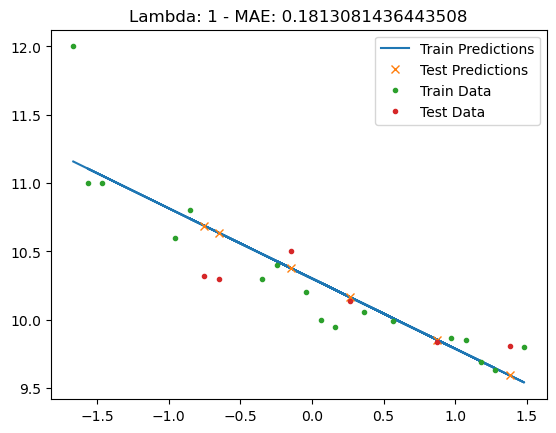

In [12]:
y_hat = ridge_model.ridge_predict(X_train)
plt.tight_layout()
plt.plot(X_train[:, 1], y_hat, label='Train Predictions')
plt.plot(X_test[:, 1], pred_test, 'x', label='Test Predictions')
plt.plot(X_train[:, 1], y_train, '.', label='Train Data')
plt.plot(X_test[:, 1], y_test, '.', label='Test Data')
plt.title(f"Lambda: {best_l} - MAE: {mean_absolute_error(y_test, pred_test)}")
plt.legend()

In [17]:
# test with sklearn
ridge_model2 = Ridge(alpha=best_l)
ridge_model2.fit(X_train[:, 1].reshape(-1, 1), y_train)

sklearn_pred_val = ridge_model2.predict(X_val[:, 1].reshape(-1, 1))

sklearn_pred_test = ridge_model2.predict(X_test[:, 1].reshape(-1, 1))
# difference between our model predicions and sklearn ones
diff_val = pred_val - sklearn_pred_val
diff_test = pred_test - sklearn_pred_test
mean_absolute_error(sklearn_pred_test, pred_test)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.77635684e-15, 0.00000000e+00])

In [14]:
ridge_model2.intercept_, ridge_model2.coef_

(10.30235294117647, array([-0.51354422]))

In [15]:
# comparison with lasso
lasso_model = Lasso(alpha=best_l)
lasso_model.fit(X_train[:, 1].reshape(-1, 1), y_train)
lasso_model.intercept_, lasso_model.coef_
lasso_predictions = lasso_model.predict(X_test[:, 1].reshape(-1, 1))

In [16]:
mean_absolute_error(sklearn_pred_test, lasso_predictions)

0.3477098056011612